# Graded Challenge 1 Phase 1
Nama: Judan Syamsul Hadad

Batch: FTDS-009

## 1. Introduction

Selamat datang. Notebook ini dibuat sebagai pemenuhan penilaian kompetensi dari rangkaian <u>**Full Time Data Science (FTDS) Bootcamp Batch 9**</u> yang diadakan oleh Hacktiv8 dimana penulis atas nama **Judan Syamsul Hadad** dengan handlename **Riezn** merupakan salah satu pesertanya.

Dataset yang digunakan pada notebook ini dapat diunduh [disini](https://www.kaggle.com/brllrb/uber-and-lyft-dataset-boston-ma).

Dataset ini merupakan kumpulan data transaksi Uber dan Lyft yang dilengkapi dengan data cuaca saat terjadi transaksi jasa. Beberapa kolom yang bisa menjadi highlight pada dataset ini adalah `timestamp`, `source`, `destination`, `product_id`, `price`, `distance`, `temperature`, dan parameter cuaca (terik, hujan, dll).

Karena dataset diambil dari New York, maka satuan yang digunakan adalah `imperial` seperti miles untuk jarak dan fahrenheit untuk temperatur.

### 1.1. Objective
Pada notebook ini akan dilakukan regresi linier dengan tahapan berikut:
1. Exploratory Data Analysis (EDA)
2. Data preprocessing yang mencakup 
    - Cardinality
    - Splitting train set dan test set
    - Handling outliers pada train set
    - Handling missing values pada train set
    - Feature selection
    - Feature scaling dan/atau encoding
3. Model definition
4. Model training
5. Model evaluation
6. Model inference

### 1.2. Problem Statement
Hipotesis:

Prediksi `price` `Uber` dipengaruhi oleh `distance`, `surge_multiplier`, `cuaca`, `hari` dan `hour`.

## 2. Import Libraries

In [392]:
# Define Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For Regression Problems
from sklearn.linear_model import Lasso

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from feature_engine.outliers import Winsorizer

# Evaluate Regression Models
from sklearn.metrics import r2_score

## 3. Data Loading

Load dataset dari direktori yang sama dengan notebook ini.

In [393]:
#load dataset
data = pd.read_csv('rideshare_kaggle.csv')
data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


Copy dataset.

In [394]:
df = data.copy()

Cek properties dataset.

In [395]:
#cek dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

Dataset ini terdiri dari 693071 baris dan 57 kolom. Dari rangkuman di atas sudah ditemukan ada missing value pada kolom `price`.

In [396]:
#cek jumlah missing value pada price
df['price'].isna().sum()

55095

 Pengecekan lebih lanjut terkait missing values akan dilakukan pada bab `Data Preprocessing`. Cek apakah ada duplikat pada dataset berdasarkan kolom `id`.

In [397]:
#cek duplikat pada id
df.duplicated(subset='id').sum()

0

Tidak ditemukan duplikat. Selanjutnya cek statistika deskriptif dari dataset ini.

In [398]:
#cek statistika deskriptif
df.describe()

,timestamp,hour,day,month,price,distance,surge_multiplier,latitude,longitude,temperature,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
count,6.930710e+05,693071.000000,693071.000000,693071.000000,637976.000000,693071.000000,693071.000000,693071.000000,693071.000000,693071.000000,...,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05,693071.000000,6.930710e+05
mean,1.544046e+09,11.619137,17.794365,11.586684,16.545125,2.189430,1.013870,42.338172,-71.066151,39.584388,...,0.037374,1.544044e+09,33.457774,1.544042e+09,45.261313,1.544047e+09,29.731002,1.544048e+09,41.997343,1.544048e+09
std,6.891925e+05,6.948114,9.982286,0.492429,9.324359,1.138937,0.091641,0.047840,0.020302,6.726084,...,0.055214,6.912028e+05,6.467224,6.901954e+05,5.645046,6.901353e+05,7.110494,6.871862e+05,6.936841,6.910777e+05
min,1.543204e+09,0.000000,1.000000,11.000000,2.500000,0.020000,1.000000,42.214800,-71.105400,18.910000,...,0.000000,1.543162e+09,15.630000,1.543122e+09,33.510000,1.543154e+09,11.810000,1.543136e+09,28.950000,1.543187e+09
25%,1.543444e+09,6.000000,13.000000,11.000000,9.000000,1.280000,1.000000,42.350300,-71.081000,36.450000,...,0.000000,1.543421e+09,30.170000,1.543399e+09,42.570000,1.543439e+09,27.760000,1.543399e+09,36.570000,1.543439e+09
50%,1.543737e+09,12.000000,17.000000,12.000000,13.500000,2.160000,1.000000,42.351900,-71.063100,40.490000,...,0.000400,1.543770e+09,34.240000,1.543727e+09,44.680000,1.543788e+09,30.130000,1.543745e+09,40.950000,1.543788e+09
75%,1.544828e+09,18.000000,28.000000,12.000000,22.500000,2.920000,1.000000,42.364700,-71.054200,43.580000,...,0.091600,1.544807e+09,38.880000,1.544789e+09,46.910000,1.544814e+09,35.710000,1.544789e+09,44.120000,1.544818e+09
max,1.545161e+09,23.000000,30.000000,12.000000,97.500000,7.860000,3.000000,42.366100,-71.033000,57.220000,...,0.145900,1.545152e+09,43.100000,1.545192e+09,57.870000,1.545109e+09,40.050000,1.545134e+09,57.200000,1.545109e+09


Dari 57 kolom, ada 46 kolom yang dapat dilakukan analisis statistik deskriptif.

Sekilas dapat dilihat kalau rata-rata `price` 16.55 USD dengan rata-rata `distance` 2.19 miles, sedangkan di nilai maksimumnya sebesar 97.50 USD dengan jarak 7.86 miles. `price` dan `distance` pada mean dan maksimum tersebut tidak memiliki pengali yang tidak sama. Ada faktor-faktor lain yang perlu dieksplorasi dan analisis untuk mengestimasi `price`.

Hal lain yang perlu diperhatikan adalah data ini diambil hanya dalam kurun waktu dua bulan pada bulan November dan Desember jika dilihat dari nilai minimum dan maksimum untuk `month`.

Sekarang cek jumlah unique value dari masing-masing kolom.

In [399]:
#cek jumlah unique value masing-masing kolom
df.nunique().sort_values(ascending=False)

id                             693071
timestamp                       36179
datetime                        31350
distance                          549
apparentTemperature               319
pressure                          316
dewPoint                          313
temperature                       308
windSpeed                         291
windGust                          286
ozone                             274
visibility.1                      227
visibility                        227
windBearing                       195
price                             147
apparentTemperatureMin            137
apparentTemperatureLow            136
temperatureLow                    133
temperatureMin                    131
temperatureHigh                   129
temperatureMax                    128
apparentTemperatureMax            125
apparentTemperatureHigh           124
sunsetTime                        114
sunriseTime                       110
cloudCover                         83
precipIntens

In [400]:
#cek jumlah unique value pada beberapa kolom terakhir
for col in ['uvIndex','month','cab_type','timezone']:
    print(df[col].value_counts(),'\n')

0    533664
1    146303
2     13104
Name: uvIndex, dtype: int64 

12    406614
11    286457
Name: month, dtype: int64 

Uber    385663
Lyft    307408
Name: cab_type, dtype: int64 

America/New_York    693071
Name: timezone, dtype: int64 



Dari rangkuman unique value di atas, berikut beberapa hal yang ditemukan:
- `id` memiliki unique entry sama dengan jumlah baris pada dataset ini sehingga disimpulkan `id` merupakan primary key pada dataset ini
- `timestamp` dan `datetime` memiliki jumlah unique value di sekitar 30000, kemungkinan dua kolom ini menunjukkan nilai yang sama, tetapi diinterpretasikan berbeda karena perbedaan tipe data (`timestamp` - float vs `datetime` - object)
- `uvIndex` hanya memiliki tiga unique value, kemungkinan besar nilai ini memang riil karena dataset ini diambil pada bulan November dan Desember dimana biasanya masih dalam musim gugur atau musim dingin dimana intensitas cahaya matahari sedang rendah
- `month` memiliki dua nilai seperti yang ditunjukkan pada statistika deskriptif, yaitu November dan Desember
- `cab_type` memiliki dua nilai sesuai nama dataset, yaitu Uber dan Lyft
- `timezone` hanya memiliki satu unique entry

## 4. Exploratory Data Analysis (EDA)

Mulai dengan melihat hubungan antar variabel dengan heatmap.

<AxesSubplot:>

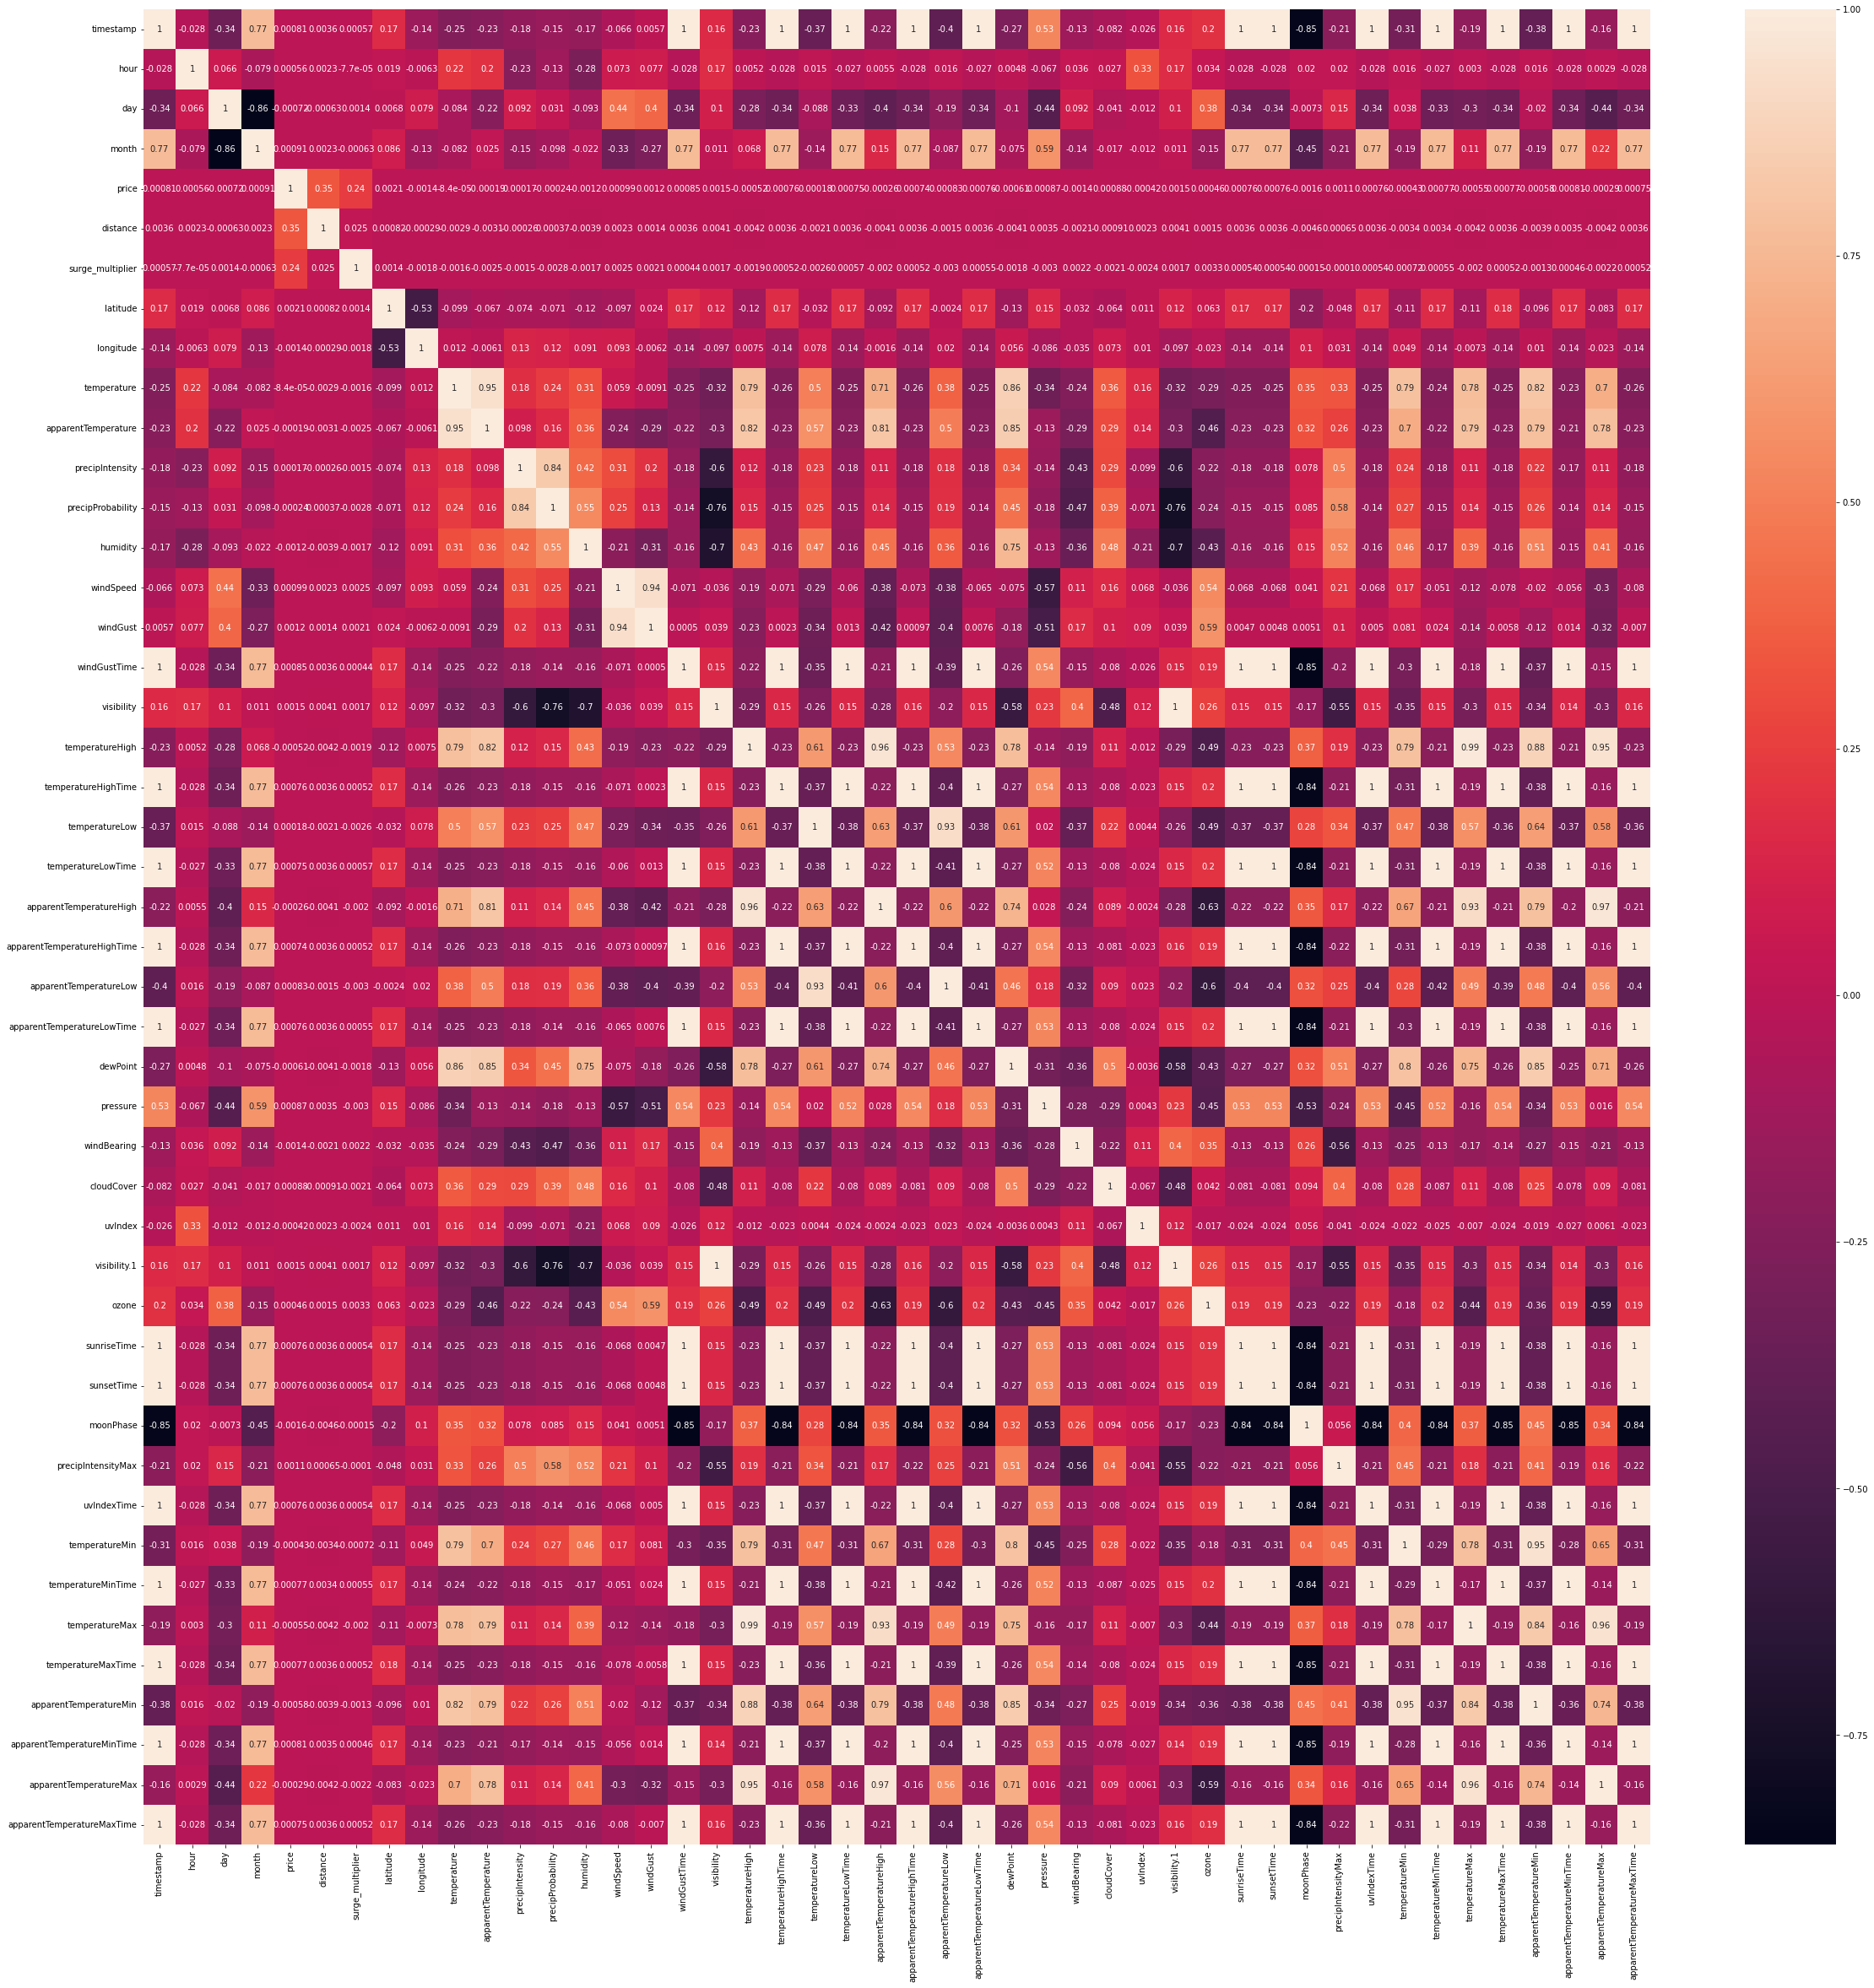

In [401]:
#cek heatmap
plt.figure(figsize=(40,40))
sns.heatmap(df.corr(),annot=True)

Terdapat banyak hubungan antar variabel yang memiliki korelasi kuat (bernilai mendekati atau sama dengan 1). Kalau diteliti, korelasi tersebut merupakan **korelasi antar variabel waktu**. Sebagai contoh bisa lihat korelasi antara `timestamp` dengan `windGustTime`.

Perlu diperhatikan bahwa variabel dengan tipe `object` tidak masuk ke dalam heatmap. Sehingga nanti tetap perlu mempertimbangkan pengaruhnya pada model di bab-bab selanjutnya.

Dari heatmap terlihat `price` memiliki korelasi dengan `distance` dan `surge_multiplier`. Beberapa feature kategorikal juga perlu dipertimbangkan untuk melihat korelasinya terhadap `price`. Berikut beberapa hubungan feature-feature atau target-feature yang akan dieksplorasi:
1. `price` terhadap `distance`
2. `price` terhadap `apparentTemperature` 
3. `price` terhadap `surge_multiplier`
4. Jumlah transaksi terhadap kondisi cuaca `short_summary` 
5. Jumlah transaksi terhadap `hour`

Sebelum itu, cek distribusi `price` pada dataset ini untuk melihat kira-kira konsentrasi data ada di rentang berapa.

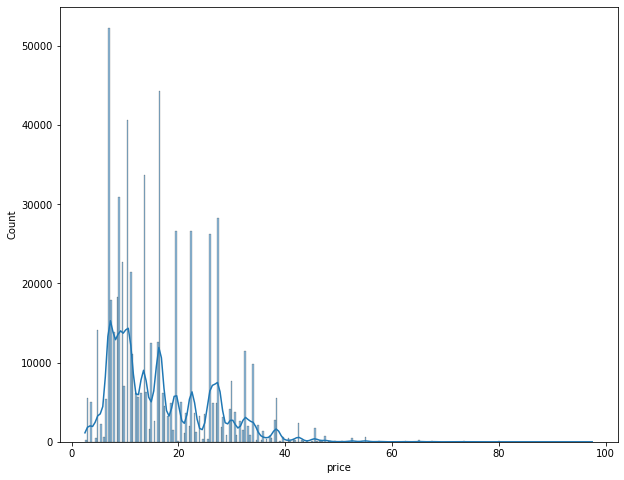

In [402]:
plt.figure(figsize=(10,8))
sns.histplot(df['price'],kde=True)
plt.show()

Sebagian besar `price` berada di rentang 0-40. Kemungkinan besar model yang dihasilkan akan lebih akurat pada rentang ini.

### 4.1. `price` terhadap `distance`
Pertama-tama cek bagaimana korelasi `price` terhadap `distance` menggunakan scatterplot dan distribusi datanya menggunakan histogram.

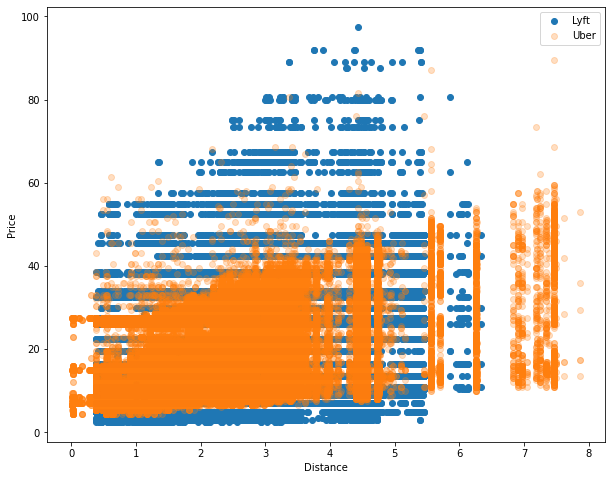

In [403]:
#visualisasi scatterplot dan histogram
plt.figure(figsize=(10,8))
plt.scatter(x=df[df['cab_type']=='Lyft']['distance'], y=df[df['cab_type']=='Lyft']['price'],label='Lyft')
plt.scatter(x=df[df['cab_type']=='Uber']['distance'], y=df[df['cab_type']=='Uber']['price'],label='Uber',alpha=0.25)
plt.xlabel('Distance')
plt.ylabel('Price')
plt.legend()
plt.show()

Pada scatter `Uber` terlihat ada suatu pola garis dengan gradien kemiringan dimana dengan bertambahnya `distance`, maka `price` pun ikut meningkat, meskipun variance-nya cukup besar. Sedangkan pola ini tidak terlihat pada scatter `Lyft`.

### 4.2. `price` terhadap `apparent temperature` 
Selanjutnya cek apakah `price` memiliki korelasi terhadap `apparent temperature`. Lihat visualisasi scatterplot di bawah ini.

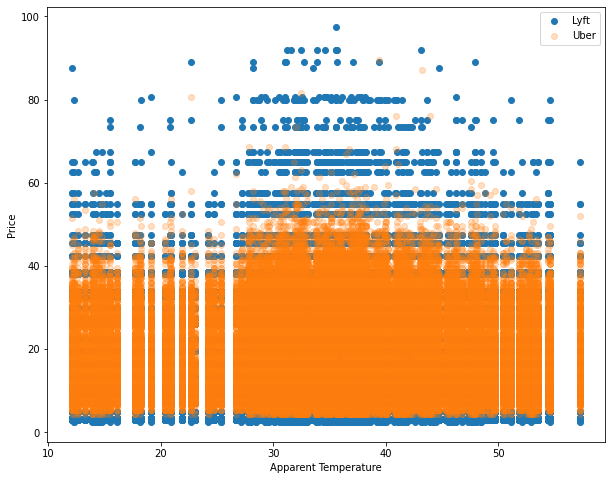

In [404]:
#visualisasi scatterplot dan histogram
plt.figure(figsize=(10,8))
plt.scatter(x=df[df['cab_type']=='Lyft']['apparentTemperature'], y=df[df['cab_type']=='Lyft']['price'],label='Lyft')
plt.scatter(x=df[df['cab_type']=='Uber']['apparentTemperature'], y=df[df['cab_type']=='Uber']['price'],label='Uber',alpha=0.25)
plt.legend()
plt.xlabel('Apparent Temperature')
plt.ylabel('Price')
plt.show()

`apparentTemperature` tidak terlihat memiliki korelasi terhadap `price` pada scatterplot. Selain itu, ada beberapa titik `apparentTemperature` dengan data yang kosong.

### 4.3. `price` terhadap `surge_multiplier` 
Selanjutnya cek apakah `price` memiliki korelasi terhadap `surge_multiplier`. Lihat visualisasi scatterplot di bawah ini.

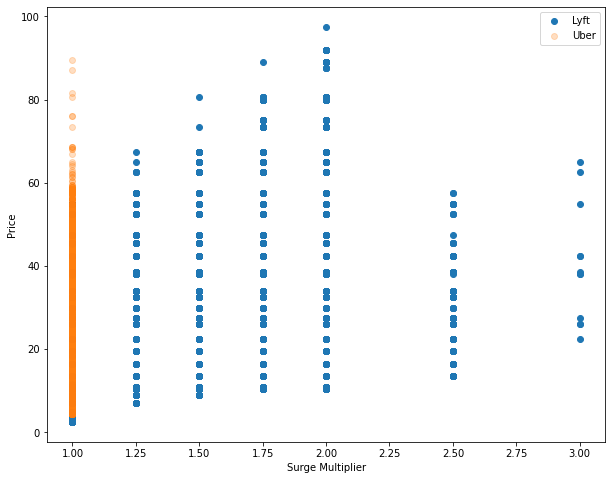

In [405]:
#visualisasi scatterplot dan histogram
plt.figure(figsize=(10,8))
plt.scatter(x=df[df['cab_type']=='Lyft']['surge_multiplier'], y=df[df['cab_type']=='Lyft']['price'],label='Lyft')
plt.scatter(x=df[df['cab_type']=='Uber']['surge_multiplier'], y=df[df['cab_type']=='Uber']['price'],label='Uber',alpha=.25)
plt.legend()
plt.xlabel('Surge Multiplier')
plt.ylabel('Price')
plt.show()

Ada yang unik disini, ternyata `Uber` hanya menggunakan satu nilai `surge_multiplier`, sedangkan `Lyft` menggunakan beberapa. `surge_multiplier` pada `Lyft` tidak terlihat membentuk suatu pola. Kemungkinan `surge_multiplier` `Lyft` dipengaruhi oleh feature kategorikal.

### 4.4. Rata-rata `price` terhadap cuaca

Selanjutnya cek hubungan `price` terhadap cuaca.

In [406]:
#grouping data
df_cuaca = df[['icon','cab_type','price']].groupby(['icon','cab_type']).aggregate(['size','mean']).droplevel(0,axis=1)
df_cuaca.sort_values(by='mean',ascending=False,inplace=True)
df_cuaca.reset_index(drop=False,inplace=True)
df_cuaca = df_cuaca.round(2)

#bar chart
plt.figure(figsize=(10,8))
fig = px.bar(data_frame=df_cuaca,x='icon',y='mean',color='cab_type',text_auto=True,barmode='group')
fig.update_layout(
    title="Rata-rata Price pada Cuaca Tertentu",
    title_x=0.5,
    xaxis_title="Cuaca",
    yaxis_title="Rata-rata Price",
    yaxis_range=[15,18],
    showlegend=True
    )
fig.show()

<Figure size 720x576 with 0 Axes>

Tidak terlihat ada beda signifikan antar kondisi cuaca. Rata-rata `price Uber` lebih rendah di berbagai cuaca dibandingkan `Lyft`.

### 4.5. Rata-rata `price` di tiap `hour`


Selanjutnya coba lihat apakah ada hubungan jumlah transaksi di tiap `hour`.

In [407]:
#grouping data
df_hour = df[['hour','cab_type','price']].groupby(['hour','cab_type']).aggregate(['size','mean']).droplevel(0,axis=1)
df_hour.sort_values(by='mean',ascending=False,inplace=True)
df_hour.reset_index(drop=False,inplace=True)
df_hour = df_hour.round(2)

#bar chart
plt.figure(figsize=(10,8))
fig = px.bar(data_frame=df_hour,x=df_hour.hour,y='mean',color='cab_type',text_auto=True,barmode='group')
fig.update_layout(
    title="Rata-rata Price pada Jam Tertentu",
    title_x=0.5,
    xaxis_title="Jam",
    yaxis_title="Rata-rata Price",
    yaxis_range=[15,18],
    showlegend=True
    )
fig.show()

<Figure size 720x576 with 0 Axes>

Tidak terlihat ada beda signifikan di tiap jam. Rata-rata `price Uber` lebih rendah di berbagai jam dibandingkan `Lyft`.

## 5. Data Preprocessing

Pada fungsi regresi linier, informasi dari `time` tidak akan berguna kecuali data yang akan di-test atau inference berada dalam rentang `time`. Jika data yang akan di-test berada di luar rentang `time` train set, yang terjadi adalah ekstrapolasi. Untuk mencegah hal tersebut, perlu dibuat sebuah terjemahan baru dari feature ini berupa nama hari, yaitu `weekday` 

In [408]:
#buat kolom baru weekday berdasarkan timestamp
df['weekday'] = pd.to_datetime(df['timestamp'], unit='s').dt.strftime('%A')

### 5.1. Cardinality

Pada bab `Data Loading` sudah dicek jumlah unique value pada masing-masing kolom. Sekarang fokus akan diberikan pada kolom dengan data kategorikal, baik yang sudah dalam bentuk numerik ordinal (`uvIndex` dan `surge_multiplier`) maupun yang masih dalam bentuk object atau string.

In [409]:
#cek cardinality
cat_cols = []
for column in df.columns:
    if (df[column].dtype == object) or (column=='uvIndex') or (column=='surge_multiplier'):
        print('Jumlah kategori pada', column, 'adalah:', df[column].nunique())
        cat_cols.append(column)

Jumlah kategori pada id adalah: 693071
Jumlah kategori pada datetime adalah: 31350
Jumlah kategori pada timezone adalah: 1
Jumlah kategori pada source adalah: 12
Jumlah kategori pada destination adalah: 12
Jumlah kategori pada cab_type adalah: 2
Jumlah kategori pada product_id adalah: 13
Jumlah kategori pada name adalah: 13
Jumlah kategori pada surge_multiplier adalah: 7
Jumlah kategori pada short_summary adalah: 9
Jumlah kategori pada long_summary adalah: 11
Jumlah kategori pada icon adalah: 7
Jumlah kategori pada uvIndex adalah: 3
Jumlah kategori pada weekday adalah: 7


Hampir semua kolom kecuali `id` dan `datetime` sudah memiliki low cardinality sehingga tidak akan diubah pada tahap ini.

### 5.2. Splitting Data

Karena notebook ini fokus pada Uber, filter data terlebih dahulu.

In [410]:
#filter data sebelum split khusus untuk Uber
df = df[df['cab_type']=='Uber']
df.shape

(385663, 58)

Dari keseluruhan entry, data Uber sebesar 385663 entry. Selanjutnya split data untuk inference.

In [411]:
#ambil data untuk inferensial
data_inf = df.sample(3, random_state=34)
data_inf.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,weekday
218978,63c92f5e-ebae-4ff3-babd-074a95ff4e75,1.543342e+09,18,27,11,2018-11-27 18:12:21,America/New_York,Northeastern University,West End,Uber,...,1543338000,35.76,1543377600,46.35,1543320000,31.80,1543377600,43.38,1543320000,Tuesday
489850,76193afe-c1ca-4326-a69b-b63d8c5c680e,1.543658e+09,9,1,12,2018-12-01 09:47:59,America/New_York,Back Bay,North End,Uber,...,1543683600,31.11,1543662000,44.82,1543690800,27.80,1543662000,44.15,1543690800,Saturday
483809,14424857-3c77-4a3a-9fdc-f74a5667a07d,1.545145e+09,14,18,12,2018-12-18 14:55:11,America/New_York,South Station,Beacon Hill,Uber,...,1545152400,23.05,1545192000,37.96,1545109200,11.83,1545134400,31.85,1545109200,Tuesday


In [412]:
#hapus data inferensial dari dataset yang akan di-split
df_tt = df.drop(data_inf.index)
df_tt.reset_index(drop=True,inplace=True)
data_inf.reset_index(drop=True,inplace=True)

Selanjutnya deklarasi feature dan target.

In [413]:
#deklarasi feature dan target
X = df_tt.drop(columns='price')
y = df_tt['price']

print('Total Feature:',X.shape)
print('Total Target:',y.shape)

Total Feature: (385660, 57)
Total Target: (385660,)


Kemudian split data menjadi train set dan test set dengan test size 20%.

In [414]:
#split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

print('Total Data Train: ', X_train.shape)
print('Total Data Test: ', X_test.shape)

Total Data Train:  (308528, 57)
Total Data Test:  (77132, 57)


### 5.3. Handling Outlier

Outlier hanya akan ditentukan dari feature numerikal. Pisahkan feature kategorikal dari numerikal terlebih dahulu.

In [415]:
#deklarasi feature numerikal dan kategorikal
X_train_cat = X_train[cat_cols]
X_train_num = X_train.drop(columns=cat_cols)

#### Outliers Detection

Selanjutnya lakukan deteksi outlier dari semua feature.

In [416]:
#deteksi outlier untuk distribusi normal

def find_normal_boundaries(dataframe, variable):
    upper_boundary = dataframe[variable].mean() + 3 * dataframe[variable].std()
    lower_boundary = dataframe[variable].mean() - 3 * dataframe[variable].std()

    return upper_boundary, lower_boundary

In [417]:
#deteksi outlier untuk distribusi skewed

def find_skewed_boundaries(dataframe, variable):
    Q1 = dataframe[variable].quantile(0.25)
    Q3 = dataframe[variable].quantile(0.75)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 1.5 * IQR
    lower_boundary = Q1 - 1.5 * IQR

    return upper_boundary, lower_boundary

In [418]:
#loop untuk pembuatan summary outlier
distribution = []
skewness = []
upper_limit = []
lower_limit = []
outliers_percent = []

for column in X_train_num.columns:
    col_skewness = X_train_num[column].skew()

    if (col_skewness >= -0.5) & (col_skewness <= 0.5):
        col_distribution = 'Normal'
        col_upper_limit, col_lower_limit = find_normal_boundaries(X_train_num,column)      

    else:
        col_distribution = 'Skewed'
        col_upper_limit, col_lower_limit = find_skewed_boundaries(X_train_num,column)
    
    col_outliers_percent = (len(X_train_num[X_train_num[column] > col_upper_limit]) + len(X_train_num[X_train_num[column] < col_lower_limit])) / len(X_train_num) * 100
    
    distribution.append(col_distribution)
    skewness.append(col_skewness)
    upper_limit.append(col_upper_limit)
    lower_limit.append(col_lower_limit)
    outliers_percent.append(col_outliers_percent)

outliers_summary = {'distribution_type':distribution, 'skewnewss':skewness, 'upper_limit':upper_limit, 'lower_limit':lower_limit,'outliers_percent':outliers_percent}
outliers_summary = pd.DataFrame(outliers_summary,index=X_train_num.columns)

In [419]:
#rangkuman feature dengan outlier dari besar ke kecil
outliers_summary.sort_values(by='outliers_percent',ascending=False,inplace=True)
outliers_summary = outliers_summary[outliers_summary['outliers_percent']>0]
outliers_summary

,distribution_type,skewnewss,upper_limit,lower_limit,outliers_percent
precipProbability,Skewed,2.013559,0.000000,0.000000,21.886182
precipIntensity,Skewed,3.306832,0.000000,0.000000,21.886182
visibility.1,Skewed,-1.499547,12.502500,5.818500,19.573588
visibility,Skewed,-1.499547,12.502500,5.818500,19.573588
latitude,Skewed,-2.103350,42.386300,42.328700,12.879220
apparentTemperatureLow,Skewed,-0.500110,46.840000,16.120000,12.734339
apparentTemperatureMin,Skewed,-1.108360,46.685000,16.405000,10.991547
apparentTemperatureMax,Skewed,0.612674,55.370000,25.290000,6.412708
dewPoint,Skewed,-0.500524,54.115000,11.515000,5.353485
temperature,Skewed,-0.611302,54.200000,25.880000,5.335010


Terdapat beberapa kolom yang memiliki outlier. Kolom-kolom tersebut akan dibagi menjadi tiga kategori:
- Outliers >15%: retain
- Outliers 5-15%: cap
- Outliers <5%: trim

In [420]:
#grouping outliers
outliers_retain = list(outliers_summary[(outliers_summary['outliers_percent']>15)].index)
outliers_capping = list(outliers_summary[(outliers_summary['outliers_percent']>=5) & (outliers_summary['outliers_percent']<=15)].index)
outliers_trimming = list(outliers_summary[(outliers_summary['outliers_percent']<5)].index)

#### Retained Outliers

In [421]:
#cek feature dengan outlier yang akan di-retain
outliers_summary.loc[outliers_retain]

,distribution_type,skewnewss,upper_limit,lower_limit,outliers_percent
precipProbability,Skewed,2.013559,0.0000,0.0000,21.886182
precipIntensity,Skewed,3.306832,0.0000,0.0000,21.886182
visibility.1,Skewed,-1.499547,12.5025,5.8185,19.573588
visibility,Skewed,-1.499547,12.5025,5.8185,19.573588


Seluruh feature dengan outlier yang akan di-retain ini merupakan parameter cuaca. Parameter ini umum terjadi dan dapat bersifat sporadik sehingga outlier-nya pun akan dibiarkan karena bukan hasil dari human error.

#### Outliers Capping

In [422]:
#cek feature dengan outlier yang akan di-cap
outliers_summary.loc[outliers_capping]

,distribution_type,skewnewss,upper_limit,lower_limit,outliers_percent
latitude,Skewed,-2.103350,42.3863,42.3287,12.879220
apparentTemperatureLow,Skewed,-0.500110,46.8400,16.1200,12.734339
apparentTemperatureMin,Skewed,-1.108360,46.6850,16.4050,10.991547
apparentTemperatureMax,Skewed,0.612674,55.3700,25.2900,6.412708
dewPoint,Skewed,-0.500524,54.1150,11.5150,5.353485
temperature,Skewed,-0.611302,54.2000,25.8800,5.335010


Kebanyakan feature yang akan dilakukan capping adalah feature `temperature` dan derivatnya. `latitude` pada dasarnya merupakan indikator posisi sehingga tidak akan dilakukan capping.

In [423]:
#simpan nama feature dengan outlier yang di-retain
outliers_retain = outliers_retain + ['latitude']

In [424]:
#deklarasi nama kolom untuk capping
outliers_capping.remove('latitude')
outliers_summary.loc[outliers_capping]

,distribution_type,skewnewss,upper_limit,lower_limit,outliers_percent
apparentTemperatureLow,Skewed,-0.500110,46.840,16.120,12.734339
apparentTemperatureMin,Skewed,-1.108360,46.685,16.405,10.991547
apparentTemperatureMax,Skewed,0.612674,55.370,25.290,6.412708
dewPoint,Skewed,-0.500524,54.115,11.515,5.353485
temperature,Skewed,-0.611302,54.200,25.880,5.335010


Karena distribusinya skewed semua, maka capping dilakukan dengan metode IQR.

In [425]:
#capping IQR
capping = Winsorizer(capping_method='iqr',
                                tail='both',
                                fold=1.5,
                                variables=outliers_capping)

capping.fit(X_train_num)

X_train_num_capped = capping.transform(X_train_num)

Nilai min dan max berubah setelah capping dengan distribusi data tetap.

#### Outliers Trimming

In [426]:
#cek feature dengan outlier yang akan di-cap
outliers_summary.loc[outliers_trimming]

,distribution_type,skewnewss,upper_limit,lower_limit,outliers_percent
windGust,Skewed,1.115594,23.260000,-7.460000,2.425388
distance,Skewed,1.011564,5.150000,-1.010000,1.890590
temperatureMin,Skewed,-0.874849,51.945000,17.105000,0.664769
apparentTemperature,Normal,-0.394969,59.601407,12.134094,0.279067


Tentukan index dari outlier yang akan di-trim.

In [427]:
#menentukan index untuk trim
trim_index = []
for col in outliers_trimming:
    upper = outliers_summary.loc[col]['upper_limit']
    lower = outliers_summary.loc[col]['lower_limit']
    trim_index.append(X_train_num_capped[~((X_train_num_capped[col]<=upper) & (X_train_num_capped[col]>=lower))].index)

trim_index = [item for sublist in trim_index for item in sublist]
trim_index = list(set(trim_index))

Cek data yang akan di-trim.

In [428]:
X_train_num_capped.loc[trim_index].head()

,timestamp,hour,day,month,distance,latitude,longitude,temperature,apparentTemperature,precipIntensity,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
131073,1.543526e+09,21,29,11,7.46,42.3519,-71.0551,41.97,36.09,0.0,...,0.0000,1543510800,35.12,1543550400,44.76,1543510800,30.850,1543550400,38.44,1543510800
163850,1.544761e+09,4,14,12,5.70,42.3559,-71.0550,31.10,31.10,0.0,...,0.0001,1544716800,18.24,1544688000,33.96,1544731200,16.405,1544688000,32.95,1544734800
163851,1.544761e+09,4,14,12,5.70,42.3559,-71.0550,31.10,31.10,0.0,...,0.0001,1544716800,18.24,1544688000,33.96,1544731200,16.405,1544688000,32.95,1544734800
262156,1.545149e+09,15,18,12,1.23,42.3647,-71.0542,27.41,16.07,0.0,...,0.0028,1545152400,23.23,1545192000,38.11,1545109200,16.405,1545134400,31.96,1545109200
262157,1.545149e+09,15,18,12,1.23,42.3647,-71.0542,27.41,16.07,0.0,...,0.0028,1545152400,23.23,1545192000,38.11,1545109200,16.405,1545134400,31.96,1545109200


In [429]:
X_train_cat.loc[trim_index].head()

,id,datetime,timezone,source,destination,cab_type,product_id,name,surge_multiplier,short_summary,long_summary,icon,uvIndex,weekday
131073,fd5e5f7b-a0bd-4785-9145-92980e7b0e43,2018-11-29 21:17:59,America/New_York,Financial District,Northeastern University,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,Black,1.0,Partly Cloudy,Partly cloudy throughout the day.,partly-cloudy-night,0,Thursday
163850,2206ea58-c73c-4569-83ec-e05cc5d301e1,2018-12-14 04:20:12,America/New_York,Financial District,Boston University,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,1.0,Overcast,Partly cloudy throughout the day.,cloudy,0,Friday
163851,46b583c2-ef4a-4e8c-bf1b-d9f2963b8f4f,2018-12-14 04:20:12,America/New_York,Financial District,Boston University,Uber,6c84fd89-3f11-4782-9b50-97c468b19529,Black,1.0,Overcast,Partly cloudy throughout the day.,cloudy,0,Friday
262156,53d6dc06-e45a-4904-a807-a5b38ccb3af7,2018-12-18 15:55:10,America/New_York,West End,North End,Uber,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,1.0,Partly Cloudy,Mostly cloudy throughout the day.,partly-cloudy-day,1,Tuesday
262157,aa5b38d1-2bf5-459a-8242-7e2cdbb4979f,2018-12-18 15:55:10,America/New_York,West End,North End,Uber,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,1.0,Partly Cloudy,Mostly cloudy throughout the day.,partly-cloudy-day,1,Tuesday


Kecuali `timezone` dan `cab_type`, tidak terlihat ada feature lain yang sama di sepanjang 5 entry pertama.

Hitung terlebih dahulu berapa banyak kira-kira data yang akan hilang dari trimming.

In [430]:
#hitung persentase
print(f'Persen data yang di-trim: {len(trim_index)/len(X_train_num_capped):.2%}')
print(f'Jumlah data yang di-trim: {len(trim_index)}')

Persen data yang di-trim: 4.93%
Jumlah data yang di-trim: 15207


Lebih kurang 4.93% data akan hilang dari trimming. Lanjutkan trimming.

In [431]:
#trim X_train_num
X_train_num_trimmed = X_train_num_capped.drop(index=trim_index)
X_train_num_trimmed.shape, X_train_num_capped.shape

((293321, 43), (308528, 43))

In [432]:
#trim X_train_cat
X_train_cat_trimmed = X_train_cat.drop(index=trim_index)
X_train_cat_trimmed.shape, X_train_cat.shape

((293321, 14), (308528, 14))

In [433]:
#trim y_train
y_train_trimmed = y_train.drop(index=trim_index)
y_train_trimmed.shape, y_train.shape

((293321,), (308528,))

Tersisa 293321 entry.

### 5.4. Handling Missing Value

Setelah semua outlier ditangani, sekarang saatnya handling missing value. Sebelumnya sudah diketahui missing value hanya ditemukan pada `price` pada dataset. Cek ulang pada train set.

In [434]:
#cek missing value pada X_train
X_train_num_trimmed.isna().sum().sum()

0

Pada X_train tidak ada missing value. Cek y_train.

In [435]:
#cek missing value pada y_train
y_train_trimmed.isna().sum()

41876

Pada y_train ditemukan missing value. Temukan index-nya.

In [436]:
#menentukan index misval
index_misval_y_train = y_train_trimmed[y_train_trimmed.isna()==True].index

Cek data dengan index tersebut.

In [437]:
X_train_num_trimmed.loc[index_misval_y_train].head()

,timestamp,hour,day,month,distance,latitude,longitude,temperature,apparentTemperature,precipIntensity,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
55090,1.545050e+09,12,17,12,2.66,42.3503,-71.0810,35.01,29.04,0.0009,...,0.0183,1545066000,34.24,1545044400,41.51,1545076800,28.430,1545044400,36.11,1545076800
67567,1.544882e+09,14,15,12,3.30,42.3661,-71.0631,47.95,46.74,0.0013,...,0.0074,1544893200,39.54,1544929200,54.47,1544896800,36.460,1544929200,53.80,1544896800
364070,1.543695e+09,20,1,12,1.25,42.3559,-71.0550,43.14,43.14,0.0000,...,0.0000,1543683600,31.57,1543658400,44.76,1543690800,27.880,1543658400,44.09,1543690800
169213,1.544763e+09,4,14,12,1.03,42.3559,-71.0550,31.10,31.10,0.0000,...,0.0001,1544716800,18.24,1544688000,33.96,1544731200,16.405,1544688000,32.95,1544734800
27991,1.543816e+09,5,3,12,2.87,42.3398,-71.0892,45.78,45.78,0.0000,...,0.0004,1543852800,42.83,1543896000,57.52,1543852800,39.650,1543896000,55.37,1543852800


In [438]:
X_train_cat_trimmed.loc[index_misval_y_train].head()

,id,datetime,timezone,source,destination,cab_type,product_id,name,surge_multiplier,short_summary,long_summary,icon,uvIndex,weekday
55090,393269ea-e221-4d39-a9ef-c9f7bbd6bcb2,2018-12-17 12:25:10,America/New_York,Theatre District,Fenway,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,1.0,Overcast,Light rain in the morning.,cloudy,0,Monday
67567,b4375fc5-527b-40fe-b054-0439b00b0a35,2018-12-15 14:00:10,America/New_York,North Station,Northeastern University,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,1.0,Overcast,Mostly cloudy throughout the day.,cloudy,1,Saturday
364070,2551ed34-683f-4c5f-b96c-ba360a68d988,2018-12-01 20:03:01,America/New_York,Financial District,Haymarket Square,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,1.0,Mostly Cloudy,Light rain in the morning and overnight.,partly-cloudy-day,0,Saturday
169213,47beefa6-3685-40a9-b868-4579b5ad7df3,2018-12-14 04:55:07,America/New_York,North End,North Station,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,1.0,Overcast,Partly cloudy throughout the day.,cloudy,0,Friday
27991,5a09b4b2-3281-47c3-8c43-01effa9cfb77,2018-12-03 05:43:02,America/New_York,Northeastern University,West End,Uber,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,1.0,Foggy,Foggy in the morning.,fog,0,Monday


Feature `name` terisi oleh `Taxi`. Jika index ini di-trim, maka model tidak akan bisa menganalisis jenis jasa `Taxi`. Maka dari itu akan dilakukan imputasi.

In [439]:
X_train_cat_trimmed.loc[index_misval_y_train]['name'].value_counts()

Taxi    41876
Name: name, dtype: int64

Cek skewness y_train.

In [440]:
y_train_trimmed.skew()

0.9880021935568425

Karena data skewed, maka  median akan digunakan untuk imputasi.

<AxesSubplot:xlabel='price', ylabel='Count'>

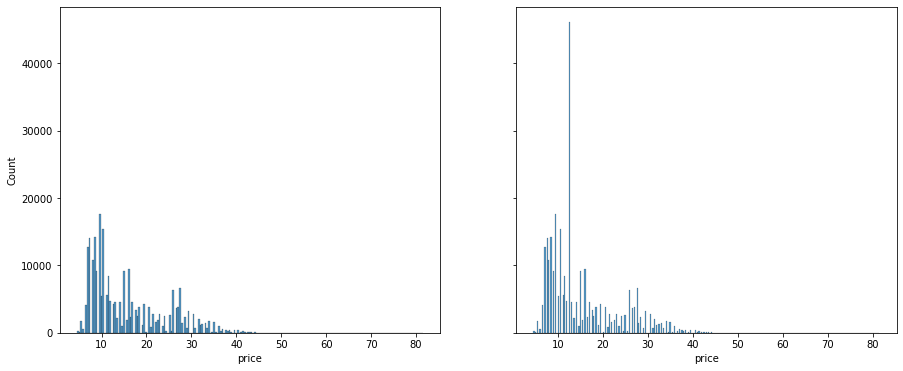

In [441]:
#cek perubahan distribusi data
fig, ax = plt.subplots(ncols=2,sharex=True,sharey=True, figsize=(15,6))
sns.histplot(y_train_trimmed,ax=ax[0])
sns.histplot(y_train_trimmed.fillna(y_train_trimmed.median()),ax=ax[1])

In [442]:
#imputasi
y_imputation = y_train_trimmed.median()
y_train_trimmed.fillna(y_train_trimmed.median(),inplace=True)
y_train_trimmed.isna().sum()

0

### 5.5. Feature Selection

Tahap berikutnya adalah feature selection. Beberapa pertimbangan yang digunakan untuk memilih feature adalah sebagai berikut:
1. Bukan primary key
2. Bukan feature dengan cardinality bernilai 1
3. Bukan feature yang redundant

#### Bukan primary key

Pada dataset ini terdapat primary key berupa `id`. Hapus feature tersebut.

In [443]:
#hapus feature id
X_train_cat_feature = X_train_cat_trimmed.drop(columns='id')
X_train_cat_feature.columns

Index(['datetime', 'timezone', 'source', 'destination', 'cab_type',
       'product_id', 'name', 'surge_multiplier', 'short_summary',
       'long_summary', 'icon', 'uvIndex', 'weekday'],
      dtype='object')

In [444]:
#simpan nama feature kategorikal yang di-drop
dropped_cols_cat = ['id']

#### Bukan feature dengan cardinality bernilai 1

Cek ulang cardinality dari train set.

In [445]:
#cek jumlah unique value untuk X_train kategorikal
X_train_cat_feature.nunique()

datetime            28802
timezone                1
source                 12
destination            12
cab_type                1
product_id              7
name                    7
surge_multiplier        1
short_summary           9
long_summary           11
icon                    7
uvIndex                 3
weekday                 7
dtype: int64

Drop feature `timezone`, `surge_multiplier`, dan `cab_type` karena keduanya hanya memiliki cardinality 1.

In [446]:
#hapus feature timezone dan cab_type
X_train_cat_feature = X_train_cat_feature.drop(columns=['timezone','cab_type','surge_multiplier'])
X_train_cat_feature.columns

Index(['datetime', 'source', 'destination', 'product_id', 'name',
       'short_summary', 'long_summary', 'icon', 'uvIndex', 'weekday'],
      dtype='object')

In [447]:
#simpan nama feature kategorikal yang di-drop
dropped_cols_cat = dropped_cols_cat + ['timezone','cab_type','surge_multiplier']

#### Bukan feature yang redundant

Penentuan feature redundant pada dasarnya mengandung subyektivitas dari penulis. Maka dari itu, penulis akan membaginya ke beberapa bagian dilengkapi dengan alasan pemilihan feature.

##### `Time`

Pada EDA telah diketahui bahwa feature `time` bersifat redundant dan memiliki korelasi 1 dengan feature `time` lainnya. Dari keseluruhan feature `time`, feature `weekday` dan `hour` akan dipilih untuk merepresentasikan seluruh feature `time`.

In [448]:
#simpan nama feature yang di-drop
time_cols_cat = [col for col in X_train_cat_feature.columns if ('time' in col or 'Time' in col)]
time_cols_cat

['datetime']

In [449]:
#simpan nama feature yang di-drop
time_cols_num = [col for col in X_train_num_trimmed.columns if 'Time' in col] + ['day', 'month', 'timestamp']
time_cols_num

['windGustTime',
 'temperatureHighTime',
 'temperatureLowTime',
 'apparentTemperatureHighTime',
 'apparentTemperatureLowTime',
 'sunriseTime',
 'sunsetTime',
 'uvIndexTime',
 'temperatureMinTime',
 'temperatureMaxTime',
 'apparentTemperatureMinTime',
 'apparentTemperatureMaxTime',
 'day',
 'month',
 'timestamp']

Pada data kategorikal ada feature `datetime`, sedangkan pada data numerikal ada beberapa feature `time`.

In [450]:
#drop feature
X_train_cat_feature = X_train_cat_feature.drop(columns=time_cols_cat)
X_train_cat_feature.columns

Index(['source', 'destination', 'product_id', 'name', 'short_summary',
       'long_summary', 'icon', 'uvIndex', 'weekday'],
      dtype='object')

In [451]:
#drop feature
X_train_num_feature = X_train_num_trimmed.drop(columns=time_cols_num)
X_train_num_feature.columns

Index(['hour', 'distance', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'precipIntensity', 'precipProbability',
       'humidity', 'windSpeed', 'windGust', 'visibility', 'temperatureHigh',
       'temperatureLow', 'apparentTemperatureHigh', 'apparentTemperatureLow',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'visibility.1',
       'ozone', 'moonPhase', 'precipIntensityMax', 'temperatureMin',
       'temperatureMax', 'apparentTemperatureMin', 'apparentTemperatureMax'],
      dtype='object')

In [452]:
#simpan nama feature yang di-drop
dropped_cols_cat = dropped_cols_cat + time_cols_cat
dropped_cols_num = time_cols_num

##### `Temperature`

Pada dataset ini terdapat beberapa feature yang berhubungan dengan `temperature` seperti `apparentTemperature`. Feature ini merupakan sebuah nilai yang merepresentasikan temperatur yang dirasakan oleh manusia berdasarkan parameter cuaca saat itu. Berdasarkan [pernyataan]('https://meteor.geol.iastate.edu/~ckarsten/bufkit/apparent_temperature.html') dari Iowa State University, `apparentTemperature` dihitung menggunakan `Temperature`, `humidity`, dan `windSpeed`. Sehingga kumpulan feature ini bisa direpresentasikan dengan `apparentTemperature` saja karena `apparentTemperature` sendiri dihitung menggunakan kombinasi dari feature yang sudah disebutkan berdasarkan kondisi cuaca. Pada temperatur tertentu ada feature yang justru tidak digunakan sama sekali untuk perhitungan `apparentTemperature`.

In [453]:
#simpan nama feature yang di-drop
temp_cols = [col for col in X_train_num_feature.columns if ('Temperature' in col or 'temperature' in col)]
temp_cols.remove('apparentTemperature')
temp_cols = temp_cols + ['humidity','windSpeed']
temp_cols

['temperature',
 'temperatureHigh',
 'temperatureLow',
 'apparentTemperatureHigh',
 'apparentTemperatureLow',
 'temperatureMin',
 'temperatureMax',
 'apparentTemperatureMin',
 'apparentTemperatureMax',
 'humidity',
 'windSpeed']

In [454]:
#drop feature
X_train_num_feature = X_train_num_feature.drop(columns=temp_cols)
X_train_num_feature.columns

Index(['hour', 'distance', 'latitude', 'longitude', 'apparentTemperature',
       'precipIntensity', 'precipProbability', 'windGust', 'visibility',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'visibility.1',
       'ozone', 'moonPhase', 'precipIntensityMax'],
      dtype='object')

In [455]:
#simpan nama feature yang di-drop
dropped_cols_num = dropped_cols_num + temp_cols

##### `Weather`

Sampai sejauh ini, cek ulang feature apa saja yang masih ada.

In [456]:
X_train_cat_feature.columns

Index(['source', 'destination', 'product_id', 'name', 'short_summary',
       'long_summary', 'icon', 'uvIndex', 'weekday'],
      dtype='object')

In [457]:
X_train_num_feature.columns

Index(['hour', 'distance', 'latitude', 'longitude', 'apparentTemperature',
       'precipIntensity', 'precipProbability', 'windGust', 'visibility',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'visibility.1',
       'ozone', 'moonPhase', 'precipIntensityMax'],
      dtype='object')

Feature redundant berikutnya yang akan dievaluasi adalah feature cuaca. Cuaca sendiri pada dasarnya dipengaruhi oleh beberapa faktor dan pada dataset ini sudah terdapat tiga feature cuaca secara kategorikal, yaitu `short_summary`, `long_summary`, dan `icon`. Sekarang lihat terlebih dahulu unique value pada tiga feature tersebut.

In [458]:
X_train_cat_feature['short_summary'].value_counts() 

 Overcast             93524
 Mostly Cloudy        59696
 Partly Cloudy        53962
 Clear                35996
 Light Rain           24117
 Rain                 10436
 Possible Drizzle      8293
 Foggy                 4012
 Drizzle               3285
Name: short_summary, dtype: int64

In [459]:
X_train_cat_feature['long_summary'].value_counts() 

 Mostly cloudy throughout the day.                      81495
 Partly cloudy throughout the day.                      60838
 Light rain in the morning.                             44925
 Rain throughout the day.                               23682
 Light rain in the morning and overnight.               22099
 Rain until morning, starting again in the evening.     20903
 Foggy in the morning.                                  19435
 Light rain until evening.                              15498
 Overcast throughout the day.                            3337
 Possible drizzle in the morning.                         884
 Rain in the morning and afternoon.                       225
Name: long_summary, dtype: int64

In [460]:
X_train_cat_feature['icon'].value_counts() 

 cloudy                  93524
 partly-cloudy-night     66474
 partly-cloudy-day       47184
 rain                    46131
 clear-night             24423
 clear-day               11573
 fog                      4012
Name: icon, dtype: int64

Dari ketiga feature tersebut, `icon` bisa lebih menjelaskan kondisi cuaca saat transaksi dengan lebih singkat dan jelas. Selain itu, cuaca juga merupakan derivat dari parameter cuaca lainnya sehingga model bisa disederhanakan dengan menghapus beberapa feature redundant lainnya sesuai penjelasan pada link [ini]('https://www.meteomatics.com/en/api/available-parameters/standard-weather-parameter/'). Feature-feature tersebut yang belum dihapus adalah `precipIntensity`, `precipProbability`, `windGust`, `visibility`, `dewPoint`, `pressure`, `windBearing`, `cloudCover`, `visibility.1`, `moonPhase`(cek [disini]('https://www.tomorrow.io/weather/blog/moon-impact-weather/#:~:text=The%20Moon%20and%20Rainfall&text=Research%20by%20the%20University%20of,of%20rain%20that%20falls%20below.')), `ozone`, `precipIntensityMax`, dan `uvIndex`.

Dari penjelasan tersebut, tersisa feature berikut:

In [461]:
#simpan nama feature yang di-drop dan drop feature
weather_cat_cols = ['short_summary','long_summary','uvIndex']
X_train_cat_feature = X_train_cat_feature.drop(columns=weather_cat_cols)
X_train_cat_feature.columns

Index(['source', 'destination', 'product_id', 'name', 'icon', 'weekday'], dtype='object')

In [462]:
#simpan nama feature yang di-drop dan drop feature
weather_num_cols = ['precipIntensity','precipProbability','windGust','visibility','dewPoint','pressure','windBearing','cloudCover','visibility.1','ozone','moonPhase','precipIntensityMax']
X_train_num_feature = X_train_num_feature.drop(columns=weather_num_cols)
X_train_num_feature.columns

Index(['hour', 'distance', 'latitude', 'longitude', 'apparentTemperature'], dtype='object')

In [463]:
#simpan nama feature yang di-drop
dropped_cols_num = dropped_cols_num + weather_num_cols
dropped_cols_cat = dropped_cols_cat + weather_cat_cols

##### `Service Type`

Feature selanjutnya yang akan dievaluasi adalah jenis servis. Pada feature kategorikal terdapat feature `name` dan `product_id`. Sekarang cek unique value pada keduanya.

In [464]:
X_train_cat_feature['name'].value_counts()

UberPool     42009
Black SUV    41977
Black        41960
UberX        41884
Taxi         41876
WAV          41830
UberXL       41785
Name: name, dtype: int64

In [465]:
X_train_cat_feature['product_id'].value_counts()

997acbb5-e102-41e1-b155-9df7de0a73f2    42009
6d318bcc-22a3-4af6-bddd-b409bfce1546    41977
6c84fd89-3f11-4782-9b50-97c468b19529    41960
55c66225-fbe7-4fd5-9072-eab1ece5e23e    41884
8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a    41876
9a0e7b09-b92b-4c41-9779-2ad22b4d779d    41830
6f72dfc5-27f1-42e8-84db-ccc7a75f6969    41785
Name: product_id, dtype: int64

Kedua feature ini redundant, maka gunakan feature `name` saja.

In [466]:
X_train_cat_feature = X_train_cat_feature.drop(columns='product_id')
X_train_cat_feature.columns

Index(['source', 'destination', 'name', 'icon', 'weekday'], dtype='object')

In [467]:
#simpan nama feature yang di-drop
dropped_cols_cat = dropped_cols_cat + ['product_id']

##### `Location`

Feature ini merupakan feature terakhir yang akan dievaluasi. Feature `location` ini pada dasarnya merupakan titik jemput dan titik antar, tetapi pada feature numerikal terdapat `longitude` dan `latitude` yang juga menggambarkan posisi. Posisi apa yang digambarkan tidak dijelaskan pada dataset ini sehingga feature yang akan disimpan dan digunakan adalah `source` dan `destination`.

In [468]:
#simpan nama feature yang di-drop dan drop feature
loc_cols = ['latitude','longitude']
X_train_num_feature = X_train_num_feature.drop(columns=loc_cols)
X_train_num_feature.columns

Index(['hour', 'distance', 'apparentTemperature'], dtype='object')

In [469]:
#simpan nama feature yang di-drop
dropped_cols_num = dropped_cols_num + loc_cols

##### Kesimpulan Feature

Berikut feature yang akan digunakan pada model linear regression.

In [470]:
retained_cat_features = list(X_train_cat_feature.columns)
retained_cat_features

['source', 'destination', 'name', 'icon', 'weekday']

In [471]:
retained_num_features = list(X_train_num_feature.columns)
retained_num_features

['hour', 'distance', 'apparentTemperature']

Secara keseluruhan ada 8 feature. Berikut feature yang tidak digunakan untuk pemodelan.

In [472]:
dropped_cols_cat

['id',
 'timezone',
 'cab_type',
 'surge_multiplier',
 'datetime',
 'short_summary',
 'long_summary',
 'uvIndex',
 'product_id']

In [473]:
dropped_cols_num

['windGustTime',
 'temperatureHighTime',
 'temperatureLowTime',
 'apparentTemperatureHighTime',
 'apparentTemperatureLowTime',
 'sunriseTime',
 'sunsetTime',
 'uvIndexTime',
 'temperatureMinTime',
 'temperatureMaxTime',
 'apparentTemperatureMinTime',
 'apparentTemperatureMaxTime',
 'day',
 'month',
 'timestamp',
 'temperature',
 'temperatureHigh',
 'temperatureLow',
 'apparentTemperatureHigh',
 'apparentTemperatureLow',
 'temperatureMin',
 'temperatureMax',
 'apparentTemperatureMin',
 'apparentTemperatureMax',
 'humidity',
 'windSpeed',
 'precipIntensity',
 'precipProbability',
 'windGust',
 'visibility',
 'dewPoint',
 'pressure',
 'windBearing',
 'cloudCover',
 'visibility.1',
 'ozone',
 'moonPhase',
 'precipIntensityMax',
 'latitude',
 'longitude']

Sekarang pastikan dari heatmap supaya tidak ada lagi feature yang berkorelasi tinggi.

<AxesSubplot:>

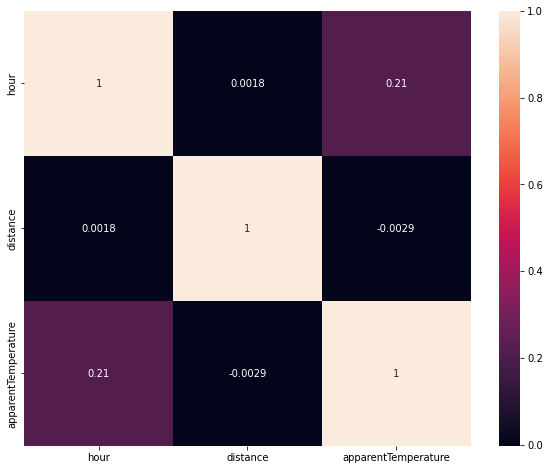

In [474]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train_num_feature.corr(),annot=True)

Dari heatmap sudah tidak ditemukan feature dengan korelasi tinggi.

#### Preprocessing test set

Jangan lupa untuk menyamakan feature pada test set dan menghapus data dengan missing value pada y_test.

In [475]:
#cek missing value y_test
y_test.isna().sum()

#imputasi misval y_test dengan median y_train
y_test = y_test.fillna(y_imputation)

#deklarasi feature numerikal dan kategorikal
X_test_cat = X_test[cat_cols]
X_test_num = X_test.drop(columns=cat_cols)

#drop feature
X_test_cat_feature = X_test_cat.drop(columns=dropped_cols_cat)
X_test_num_feature = X_test_num.drop(columns=dropped_cols_num)

### 5.6. Feature Scaling

Pada model linear regression, umumnya digunakan StandardScaler pada feature numerikal agar tidak terdapat variance yang besar sekali. Jika terdapat variance yang terlalu besar, maka model akan bias.

In [476]:
#feature scaling dengan standardscaler
scaler = StandardScaler()
scaler.fit(X_train_num_feature)

X_train_num_scaled = scaler.transform(X_train_num_feature)
X_test_num_scaled = scaler.transform(X_test_num_feature)

### 5.7. Feature Encoding

Untuk feature kategorikal akan dilakukan one hot encoding.

In [477]:
#feature encoding dengan onehotencoder
onehot_encoder = OneHotEncoder()
onehot_encoder.fit(X_train_cat_feature)

X_train_cat_enc = onehot_encoder.transform(X_train_cat_feature).toarray()
X_test_cat_enc = onehot_encoder.transform(X_test_cat_feature).toarray()

### 5.8. Final Feature

Gabungkan feature menjadi satu.

In [478]:
X_train_final = np.concatenate([X_train_num_scaled,X_train_cat_enc], axis=1)
X_test_final = np.concatenate([X_test_num_scaled,X_test_cat_enc], axis=1)

## 6. Model Definition

Pemodelan akan dilakukan menggunakan regresi linier dengan regularisasi Lasso atau L1. Regularisasi dilakukan untuk mencegah overfitting karena jumlah one hot encoding pada feature. Hyperparameter yang digunakan adalah alpha dengan tiga variasi, yaitu 0.1, 0.5, 1, 2, dan 10. Hyperparameter lain adalah fit_intercept yang di-set sebagai True karena data ini tidak diketahui sudah `centered` atau belum. 

Metrics yang digunakan untuk evaluasi model adalah R2 score dimana korelasi bagus akan menghasilkan angka mendekati 1, sedangkan korelasi buruk mendekati 0. R2 score yang dinyatakan bagus bisa berbeda-beda tergantung bidang studi (ekonomi, fisika molekular, dll.). Umumnya korelasi bagus didapatkan pada nilai 0.75 ke atas dan pada notebook ini akan menggunakan asumsi tersebut.

Definisi model dapat dilihat pada cell di bawah.

**Catatan: Pada training akan digunakan beberapa variasi hyperparameter alpha dan dibandingkan terhadap regresi linear tanpa regularisasi**

In [479]:
model = Lasso(alpha=0.1,fit_intercept=True)

## 7. Model Training

In [480]:
#variabel untuk summary
alpha = [0.1, 0.5, 1, 2, 10]
r2_train = []
r2_test = []
y_pred = []

#loop prediksi dengan variasi hyperparameter alpha
for n in alpha:
    #definisi model
    model = Lasso(alpha=n, fit_intercept=True)
    
    #training dan testing model
    model.fit(X_train_final,y_train_trimmed)
    y_train_pred_ridge = model.predict(X_train_final)
    y_test_pred_ridge = model.predict(X_test_final)
    r2_train.append(r2_score(y_train_trimmed,y_train_pred_ridge))
    r2_test.append(r2_score(y_test,y_test_pred_ridge))
    y_pred.append(y_test_pred_ridge)

#dataframe untuk visualisasi
y_test_table = pd.DataFrame(y_pred,index=alpha).T
y_test_table = pd.concat([y_test_table,y_test.reset_index(drop=True)],axis=1)
y_test_table.sort_values(by='price',ascending=True,inplace=True)

#dataframe untuk summary
model_summary = {'alpha':alpha, 'R2 Train':r2_train,'R2 Test':r2_test}
model_summary = pd.DataFrame(model_summary).round({'R2 Train':5,'R2 Test':5})

## 8. Model Evaluation

Rangkuman evaluasi model Lasso dapat dilihat pada tabel berikut:

In [481]:
model_summary

,alpha,R2 Train,R2 Test
0,0.1,0.90547,0.89575
1,0.5,0.76090,0.75087
2,1.0,0.52969,0.52267
3,2.0,0.07924,0.07857
4,10.0,0.00000,-0.00049


Dengan meningkatnya alpha, maka semakin besar nilai komponen regularisasi Lasso dan sebagai akibatnya akan semakin banyak feature yang dihapus. Bisa dilihat pada alpha 0.1 akurasi yang didapat paling tinggi dibandingkan nilai alpha yang lain.

Model ini juga fit antara train dengan test karena R2 score-nya tidak berbeda jauh. Model yang akan digunakan adalah model dengan alpha 0.1. Visualisasi nilai prediksi dapat dilihat pada grafik berikut:

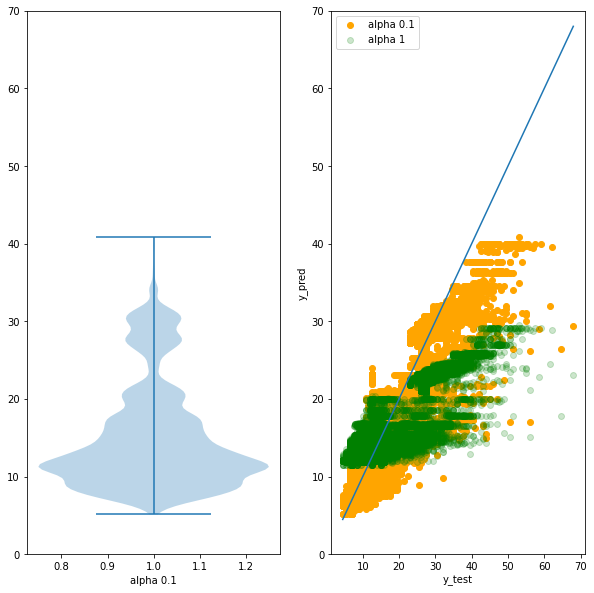

In [498]:
fig, ax = plt.subplots(ncols=2,figsize=(10,10))
plt.xlabel('y_test')
plt.ylabel('y_pred')
ax[1].plot(y_test_table['price'],y_test_table['price'])
ax[1].scatter(y_test_table['price'],y_test_table[0.1],color='orange',label='alpha 0.1')
ax[1].scatter(y_test_table['price'],y_test_table[1],color='green',alpha=0.2,label='alpha 1')

ax[0].violinplot(y_test_table[0.1])
ax[0].set_ylim(0,70)
ax[1].set_ylim(0,70)
ax[0].set_xlabel('alpha 0.1')
ax[1].legend()
plt.show()

Scatter berwarna hijau terlihat memiliki slope yang lebih datar dibandingkan scatter berwarna oranye dan memang R2 score-nya juga lebih rendah. Slope scatter oranye terlihat lebih mendekati dengan garis y_test = y_pred.

Definisikan dan training ulang model yang terpilih (alpha 0.1) untuk digunakan pada inference.

In [484]:
model = Lasso(alpha=0.1,fit_intercept=True)
model.fit(X_train_final,y_train_trimmed)

Lasso(alpha=0.1)

Sekarang cek intercept dan koefisiennya.

In [485]:
model.intercept_

12.498966081210167

In [486]:
#buat label coef
i = 0
coef_name = []
coef_label = []
coef_label += retained_num_features
while i < len(onehot_encoder.categories_):
    coef_name = onehot_encoder.categories_[i].flatten().tolist()
    coef_label+= coef_name
    i+=1

In [487]:
#buat dataframe coef
model_coef_sum = pd.DataFrame(model.coef_,index=coef_label)
model_coef_sum.rename(columns={0:'coef'},inplace=True)
model_coef_sum[model_coef_sum['coef']!=0]

,coef
distance,2.082165
Black,7.006192
Black SUV,16.760113
UberPool,-3.155100
UberX,-2.154950
UberXL,2.263771
WAV,-2.156610


Dari koefisien model bisa disimpulkan bahwa feature yang berpengaruh hanya `distance` dan jenis servis `name`.

## 9. Model Inference

Selanjutnya lakukan model inference menggunakan data inference yang sudah di-split di awal dan model yang terpilih. Definisikan feature dan label terlebih dahulu.

In [488]:
#drop label
data_inf2 = data_inf.drop('price',axis=1)

Pisah feature numerikal dan kategorikal.

In [489]:
data_inf_num = data_inf2[retained_num_features]
data_inf_cat = data_inf2[retained_cat_features]

Scale dan encode feature.

In [490]:
#feature scaling & encoding
data_inf_num_scl = scaler.transform(data_inf_num)
data_inf_cat_enc = onehot_encoder.transform(data_inf_cat).toarray()

Gabung feature numerikal dan kategorikal.

In [491]:
data_inf_final = np.concatenate([data_inf_num_scl,data_inf_cat_enc], axis=1)

Lakukan prediksi menggunakan data inference.

In [492]:
#predict inference-set

y_pred_inf = model.predict(data_inf_final)

data_inf['price-pred'] = y_pred_inf
data_inf[retained_num_features + retained_cat_features + ['price-pred']]

,hour,distance,apparentTemperature,source,destination,name,icon,weekday,price-pred
0,18,2.86,36.10,Northeastern University,West End,WAV,cloudy,Tuesday,11.847476
1,9,2.33,27.83,Back Bay,North End,Taxi,partly-cloudy-night,Saturday,12.939112
2,14,2.58,14.77,South Station,Beacon Hill,UberX,partly-cloudy-day,Tuesday,11.286509


Inference berhasil dilakukan untuk ketiga data inference.

## 10. Pengambilan Kesimpulan
Berdasarkan model yang telah dibuat, berikut kesimpulan yang didapat:
1. Koefisien dari model menunjukkan bahwa `price` dapat diprediksi cukup dengan feature `distance` dan jenis servis `name`
2. Model ini terbatas pada jenis servis yang dideskripsikan pada model ini, yaitu `UberPool, Taxi, Black, WAV, UberX, UberXL, dan Black SUV`
3. Model terbaik didapat dengan nilai alpha 0.1 dan model semakin akurat dengan alpha yang semakin mengecil